In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

# Multiple Testing approach to Survival Analysis


Abstract

In some cases the log-rank test fails to detect the effect much more often than an approaoch based on mulitple testing. We present a survival model demonstrating this case, sating that events in each group follows a Poisson distribution with typical base rate $\lambda_1(t)$ and $\lambda_2(t)$, respectively. Usually, for most measurements, we have $\lambda_1(t) = \lambda_2(t)$, whereas sometimes $\lambda_2(t) > \lambda_1(t)$ (the effect is $\lambda_2(t) - \lambda_1(t)$ for those $t$ when this difference is not zero). The model is implemented in the function `sample_survival_data` in the file `sample_survival_data.py`. 

In this notebook, we use a specific parametrization of sparsity and signal intensity in numerical simulations to find cases where higher criticism and minP tests outperform log-rank. 

To do:
- Replace exact binomial test with exact hypergeometric test. This probably does not change the asymptotic behavior of the test but will likley have better power in practice. 
- Make a power analysis across a phase space, analytically and empirically.
- Derive the asymptotic power of the log-rank test under our model.

$$
{\displaystyle E_{i,j}=N_{i,j}{\frac {O_{j}}{N_{j}}}}
$$
$$
{\displaystyle V_{i,j}=E_{i,j}\left({\frac {N_{j}-O_{j}}{N_{j}}}\right)\left({\frac {N_{j}-N_{i,j}}{N_{j}-1}}\right)}
$$

In [4]:
from survival import (log_rank_test, hypergeom_test, q95,
                      multi_pvals, atmoic_experiment, evaluate_test_stats)

## Check exponential decay

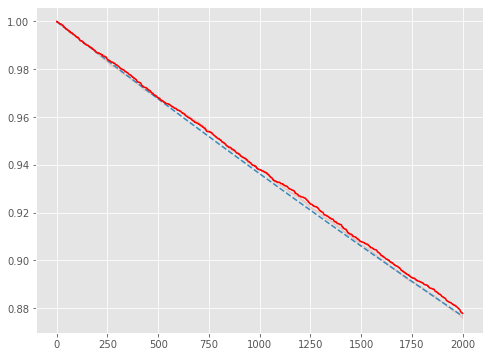

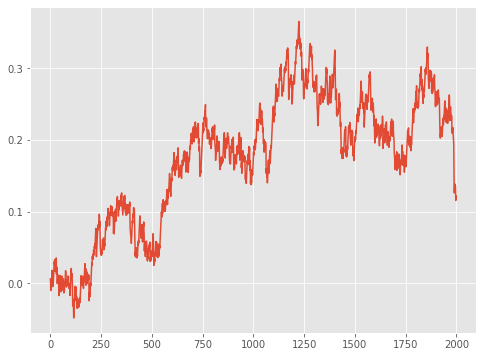

In [71]:
# this script shows that if Ny(0) = y_0,  y_0/T --> \infty and T -> \infty, then  sup_t T^\beta | e^{\lambda t} Ny(t)/Ny(0) - 1 | -> 0

T = 2000
N1 = N2 = 5 * T

beta = .6         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = 0
lam0 = np.ones(T) / T / np.log(T)
tt = np.arange(1, T+1)

plt.figure()
for _ in range(1):
    Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, eps, r)
    N0 = 2 * Nt1 * Nt2 / (Nt1 + Nt2) / N1
    plt.plot(N0, alpha=.2)
plt.plot(np.exp(-tt * lam0),'--')
plt.plot(Nt2 / N2, 'r')
plt.show()

plt.plot(T ** beta * ((Nt2[1:] / N2 * np.exp(tt * lam0)) - 1) )
plt.show()

## Check P-values

### Current issue (28/7/2022):
- Empitrical and variance-stabilized Multinomial P-values agree with theoretical log-chisquared approximation in the balanced case
- Can try and easily proove the balanced case by saying that hypergeometric p-values behaves like the binomial P-values in view of the convergence rate of $N_\star(t)$ to $N_\star(0)e^{-\bar{\lambda}t}$
- In the inbalanced case, preivous calculation shows that variance-stabilized log-chisquared parameters are independent of $\kappa$, but that implies that these P-values are better than binomial / hypergeometric. 
- Possible outlets:
 - Binomial P-values are also independent of $\kappa$
 - The dependency of binomial P-values in $\kappa$ makes them smaller hence HC is more powerful
 - There is mistake in the variance-stabilization assumptions
- To do:
 1. Verify variance stabilization by simulation
 2. Redo binomial P-values



In [19]:
def sample_perturbed(T, N1, N2, lam0, r):
    lam1 = lam0  # `base` Poisson rates (does not have to be fixed)
    lam2 = lam1
    nt = 2 * N1 * N2 / (N1 + N2)
    mu = np.sqrt(r / 2 * np.log(T))
    lam2 = (np.sqrt(mu / nt) + np.sqrt(lam1)) ** 2  # perturbed Poisson rates

    O1 = poisson.rvs(N1 * lam1)
    O2 = poisson.rvs(N2 * lam2)
    return N1 - O1, N2 - O2


def sample_perturbed2(T, N1, N2, lam0, r):
    lam1 = lam0  # `base` Poisson rates (does not have to be fixed)
    lam2 = lam1
    nt = 2 * N1 * N2 / (N1 + N2)
    mu = np.sqrt(r / 2 * np.log(T))
    lam2 = (np.sqrt(mu / nt) + np.sqrt(lam1)) ** 2  # perturbed Poisson rates

    O1 = poisson.rvs(N1 * lam1)
    O2 = poisson.rvs(N2 * lam2)
    return O1, O2


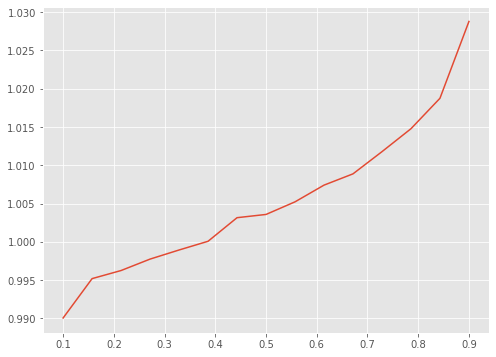

In [606]:
# Here we verify that the variance variance-stabilized poisson is independent of kappa
kk = np.linspace(0.1, .9, 15)

acc = []
for kappa in kk:
    T = 100000
    n = 20 * T # n/T -> infty
    r = 1
    n1 =n * (1 - kappa)
    n2 = n * kappa
    n0 = 2 * n1 * n2 / (n1 + n2)
    delta = r * np.log(T) / n0

    lam0 = 2 / T # lam0 * T < const
    lam1 = (np.sqrt(lam0) + np.sqrt(delta)) ** 2

    X = poisson.rvs(lam0 * n1, size = T)
    Y = poisson.rvs(lam1 * n2, size = T)

    W = np.sqrt(4 * (1 - kappa) * Y) - np.sqrt(4 * kappa * X)

    #print("STD = ",)
    std = np.std(W)
    #print("MEAN = ", np.mean(W) / np.sqrt(r) / np.sqrt(np.log(T)))
    #plt.hist(W)
    #a = kappa * (1-kappa)
    mean = np.mean(W) / np.sqrt(r) / np.sqrt(np.log(T)) / np.sqrt(2)
    acc += [mean]

plt.plot(kk, acc)
#plt.plot(kk, np.sqrt(kk * (1 - kk)))
plt.show()

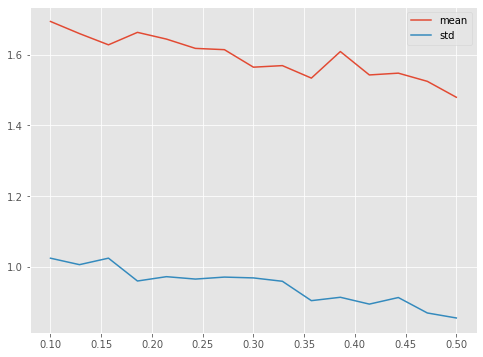

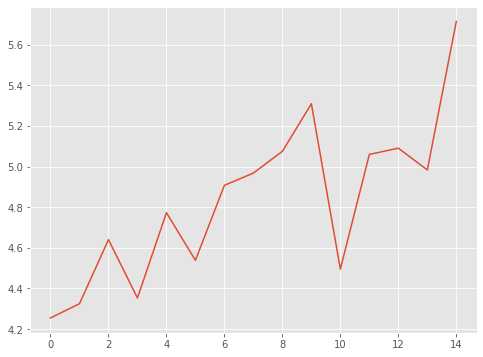

In [617]:
# here we check the binomial p-values vs. kappa
# seems like STD is stable while mean changes
# 

from twosample import binom_test_two_sided

kk = np.linspace(0.1, .5, 15)
q = .2

mm = []
ss = []
pp = []
for kappa in kk:
    T = 1000
    n = 10 * T # n/T -> infty
    r = .2
    n1 =n * (1 - kappa)
    n2 = n * kappa
    n0 = 2 * n1 * n2 / (n1 + n2)
    delta = r/2 * np.log(T) / n0

    lam0 = 2 / T # lam0 * T < const
    lam1 = (np.sqrt(lam0) + np.sqrt(delta)) ** 2

    X = poisson.rvs(lam0 * n1, size = T)
    Y = poisson.rvs(lam1 * n2, size = T)

    pvals = binom_test_two_sided(Y, X + Y, kappa, randomize=True)

    #print("STD = ",)
    W = np.sqrt(- 2 * np.log(pvals))
    std = np.std(W)
    #print("MEAN = ", np.mean(W) / np.sqrt(r) / np.sqrt(np.log(T)))
    #plt.hist(W)
    #a = kappa * (1-kappa)
    mean = np.mean( W )
    prob = np.mean(- 2 * np.log(pvals) > 2 * q * np.log(T))
    
    mm += [mean]
    ss += [std]
    pp += [- np.log(prob) / np.log(T)]

a = np.sqrt(r * np.log(T))# / np.sqrt(kk * (1 - kk))
b = 1 # / np.sqrt(kk * (1 - kk)) # np.sqrt(4 * kk * (1- kk))
plt.plot(kk, np.array(mm) / a)
plt.plot(kk, np.array(ss) / b )
#plt.plot(kk, )
plt.legend(['mean', 'std'])
plt.show()

rho = ( (np.sqrt(q) - np.sqrt(r / 2) ) / 1 ) ** 2
plt.plot(pp / rho)
plt.show()

In [615]:
pp

[0.06068896224450748,
 0.061508533533709914,
 0.06245006804270446,
 0.06518604918287234,
 0.06596065618171698,
 0.06839970947426939,
 0.06758733291601994,
 0.06911555961698579,
 0.06897201150969692,
 0.06742558447571258,
 0.07068642180936259,
 0.07300106339426775,
 0.07068642180936259,
 0.0708114106418257,
 0.08048427375641369]

In [79]:
T = 10000
N1 = 3 * T
N2 = 3 * T
kappa = N2 / (N1 + N2)

r = 0.1
lam0 = 2 / T
tt = np.arange(T)

nMonte = 10000

delta = 0.4

q = (np.sqrt(r) + np.sqrt( delta )) ** 2

ls = 0
ls_z = 0
for _ in tqdm(range(nMonte)):
    O1, O2 = sample_perturbed2(T, N1, N2, lam0, r)
    pval = multi_pvals(np.array([N1, N1 - O1]), np.array([N2, N2 - O2]), randomize=True)
    z = np.sqrt(4 * O2 * (1 - kappa) + 3/8 ) - np.sqrt(4 * O1 * kappa + 3/8)
    pval_z = norm.sf(z)
    ls += -2 * np.log(pval) > 2 * q * np.log(T)
    ls_z += -2 * np.log(pval_z) > 2 * q * np.log(T)

a = - np.log(np.mean(ls / nMonte)) / np.log(T)
a_z = - np.log(np.mean(ls_z / nMonte)) / np.log(T)

sig = np.sqrt( 4 * kappa * (1 - kappa) )
rho = r * 2 * kappa * (1 - kappa)
a_th = ((np.sqrt(q) - np.sqrt(rho))) ** 2 / sig**2

print("emp = ", a)
print("emp_z = ", a_z)
print("ratio z = ", a / a_z)
print("")
print("th = ", a_th)
print("ratio th = ", a / a_th)

100%|██████████| 10000/10000 [00:04<00:00, 2171.16it/s]

emp =  0.5387254899964357
emp_z =  0.486730389129145
ratio z =  1.1068252610245273

th =  0.5257359312880715
ratio th =  1.0247073824239847


In [51]:
np.sqrt( 4 * kappa * (1 - kappa) )

1.0

In [ ]:
(np.sqrt(r) + np.sqrt( delta )) ** 2

In [533]:
print("emp = ", a)
print("emp_z = ", a_z)
print("th = ", a_th)
print("ratio = ", a / a_th)

emp =  0.37269936941722426
emp_z =  0.3768099027432906
th =  0.251471862576143
ratio =  1.4820718532848773


In [499]:
sig = np.sqrt(4 * kappa * (1-kappa)) 
rho =  np.sqrt(2) * 2 * kappa * (1-kappa) * r 
a_th = ((np.sqrt(q) - np.sqrt(rho))) ** 2 / sig**2
a_th

0.26666666666666666

In [501]:
sig

0.8660254037844386

In [411]:
kappa = N2 / (N1 + N2)
sig = np.sqrt(4 * kappa * (1-kappa)) 
rho = 2 * kappa * (1-kappa) * r 
a_th = ((np.maximum(0, np.sqrt(q) - np.sqrt(rho)))) ** 2 / sig**2

print("emp = ", a)
print("emp_z = ", a_z)
print("th = ", a_th)


emp =  0.003620591928070305
emp_z =  0.0033832967989398627
th =  0.11333997346592446


In [401]:
rho

0.08838834764831843

In [317]:
a1 = []
a2 = []

for _ in range(10000):
    Nt1, Nt2 = sample_perturbed(T, N1, N2, lam0, r)
    pval = multi_pvals(np.array([Nt1, 0]).T, np.array([Nt2, 0]).T, randomize=True)
    O1 = N1 - Nt1
    O2 = N2 - Nt2

    a1 += [ O1 / (1 - kappa) ]
    a2 += [ O2 / (kappa) ]

In [326]:
2 * (N2 * N1) / (N1 + N2) * lam0

1.5999999999999999

0.31942380328141806
0.2909073194519745


In [101]:
- np.log(np.mean(ls)) / np.log(T)

0.3201464600743516

In [95]:
kappa = N2 / (N1 + N2)
sig = np.sqrt(4 * kappa * (1-kappa)) 
rho = 2 * kappa * (1-kappa) * r
a_th = ((np.sqrt(q) - np.sqrt(rho))/sig) ** 2

print(a_th)

0.2333920216900384


In [94]:
sig

1.0

## Sample once:

          berk_jones_greater  berk_jones_less  fisher_greater  fisher_less  \
null_95q            6.814281         6.741345        2.104427     2.107693   
observed                 NaN              NaN             NaN          NaN   
is_sig              0.000000         0.000000        0.000000     0.000000   

          hc_greater   hc_less  log_rank_greater  log_rank_less  \
null_95q    4.780447  4.677201          1.053348       1.053348   
observed         NaN       NaN               NaN            NaN   
is_sig      0.000000  0.000000          0.000000       0.000000   

          min_p_greater  min_p_less  ...  wilcoxon_less       T       N1  \
null_95q       9.885502    9.832559  ...       2.136037  1000.0  10000.0   
observed            NaN         NaN  ...            NaN     NaN      NaN   
is_sig         0.000000    0.000000  ...       0.000000     0.0      0.0   

               N2  Logrank        HC    Fisher       minP        BJ  wilcoxon  
null_95q  10000.0      NaN       

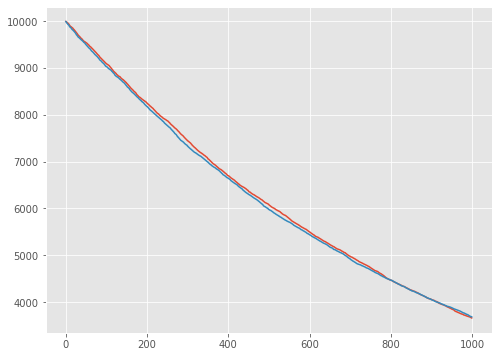

In [92]:
# single experiment non-null

T = 1000
N1 = N2 = 10000
beta = .7         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = .5
N0 = 2 * N1 * N2 / (N1 + N2)

Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, r)

lr, lr_pval = log_rank_test(Nt1, Nt2)
pvals = multi_pvals(Nt1, Nt2, randomize=True)
mt = MultiTest(pvals, stbl=False)

df_null = pd.read_csv(f"under_null_T{T}_N1_{N1}_N2_{N2}.csv").drop('Unnamed: 0', axis=1)
r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher(),
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

print("-------------------------------------------------------------\n")
print("Fliping roles of the lists:")
lr, lr_pval = log_rank_test(Nt2, Nt1)

pvals = multi_pvals(Nt2, Nt1)
mt = MultiTest(pvals, stbl=False)

r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher(),
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

tt = np.arange(T)
plt.plot(tt, Nt1[1:])
plt.plot(tt, Nt2[1:])
plt.show()
#pd.DataFrame({'N1' : Nt1, 'N2' : Nt2}).to_csv(f'surv_mu{mu}_eps{eps}.csv')


## Atomic experiment:

In [12]:
T = 1000
N1 = N2 = 2000

beta = .75         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = .5        # signal strength
nMonte = 10

lam0 = np.ones(T) / T * np.log(T)

res = pd.DataFrame()

for i in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, eps, r)
    res1 = evaluate_test_stats(Nt1, Nt2, randomized=True, alternative='both')
    res = res.append(res1, ignore_index=True)
    
res.agg(['mean', 'std'])

100%|██████████| 10/10 [00:01<00:00,  9.65it/s]


,berk_jones_greater,berk_jones_less,fisher_greater,fisher_less,hc_greater,hc_less,log_rank_greater,log_rank_less,log_rank_lifeline,min_p_greater,min_p_less,wilcoxon_greater,wilcoxon_less
mean,4.622885,4.086751,1.974149,2.013207,2.574675,2.301269,0.637197,1.513067,0.880448,8.290169,7.350922,1.440185,2.497382
std,1.494477,1.469902,0.088592,0.081203,1.009633,1.683916,0.654309,1.265068,0.753987,0.842750,1.289407,2.944974,2.450227


In [8]:
r

{'log_rank_lifeline': 46.051701859880914,
 'log_rank_greater': 1.206705255215395,
 'hc_greater': 1.6774087612912532,
 'fisher_greater': 1.9022416692239144,
 'min_p_greater': 7.6239205950012225,
 'berk_jones_greater': 6.209268022673305,
 'wilcoxon_greater': 46.051701859880914,
 'log_rank_less': 0.3555061752963663,
 'hc_less': 0.8928189288419199,
 'fisher_less': 1.996885404971436,
 'min_p_less': 5.86238390704577,
 'berk_jones_less': 2.848507827200164,
 'wilcoxon_less': -0.0}

## Many experiments

In [84]:
def evaluate(itr, T, N, beta, r):
    """
    evalaute an atomic experiment
    """
    mu = 2 * r * np.log(T) / T
    eps = T ** (-beta)
    N1 = N2 = N

    Nt1, Nt2 = sample_survival_data(int(T), int(N1), int(N2), eps, mu)
    res = evaluate_test_stats(Nt1, Nt2, randomized=True, alternative='both')
    return res


### Null Behavior

In [85]:
def simulate_null(N1, N2, T, nMonte):
    """
    Args:
    -----
    :N1:      Initial size of group 1
    :N2:      Initial size of group 2
    :T:       Total numebr of events
    :nMonte:  number of experiments to evaluate

    """
    
    df0 = pd.DataFrame()
    print("Simulating null...")
    for itr in tqdm(range(nMonte)):
        Nt1, Nt2 = sample_survival_data(T, N1, N2, 0, 0)
        res = evaluate_test_stats(Nt1, Nt2)
        df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0.agg([q95])


In [16]:
# under null
from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

#params:
T = 1000     # number of event
N = N1 = N2 = 10000    # number in group 1 and 2 at t=0

nMonte = 10000  #   number of experiments to evaluate dist. under null

df0 = simulate_null(N1, N2, T, nMonte)
# critical values under the null:
df0['T'] = T
df0['N1'] = N1
df0['N2'] = N2
df0.agg([q95]).to_csv(f"under_null_T_{T}_N1_{N1}_N2_{N2}.csv")
print(df0.agg([q95]))

  0%|          | 1/10000 [00:00<32:12,  5.17it/s]

Simulating null...


100%|██████████| 10000/10000 [26:05<00:00,  6.39it/s]


     berk_jones_greater  berk_jones_less  fisher_greater  fisher_less  \
q95            6.814281         6.741345        2.104427     2.107693   

     hc_greater   hc_less  log_rank_greater  log_rank_less  min_p_greater  \
q95    4.780447  4.677201          1.053348       1.053348       9.885502   

     min_p_less  wilcoxon_greater  wilcoxon_less       T       N1       N2  
q95    9.832559          2.112928       2.136037  1000.0  10000.0  10000.0  


### Non-Null Behavior

In [17]:
# under non-null

from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

def run_many_experiments(T, N1, N2, nMonte):
    # under non-null
    bb = np.linspace(.5, .9, 7)
    rr = np.sqrt(np.linspace(0.01, 1, 9))
    mm = 2 * rr * np.log(T) / N1

    df1 = pd.DataFrame()
    nMonte = 100       # number of experiments

    for itr in tqdm(range(nMonte)):
        for beta in bb:
            for mu in mm:
                eps = T ** -beta   # sparsity rate
                Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
                res1 = evaluate_test_stats(Nt1, Nt2)
                res2 = evaluate_test_stats(Nt2, Nt1)
                res = pd.DataFrame(res1, index=[0])
                res['mu'] = mu
                res['eps'] = eps
                res['beta'] = beta
                res['itr'] = itr
                res['T'] = T
                df1 = df1.append(res, ignore_index=True)
    return df1

df1 = run_many_experiments(T, N1, N2, nMonte)

100%|██████████| 100/100 [24:26<00:00, 14.67s/it]


In [25]:
df1['T'] = T
df1['N'] = N1
df1['N1'] = N1
df1['N2'] = N2

In how many cases both the reversed and original sides were significant?

In [89]:
df0['T'] = T
df0['N'] = N1
df0['N1'] = N1
df0['N2'] = N2

In [26]:

global_params = ['T', 'N1', 'N2']

print(df0.groupby(global_params).agg(q95))
tcrit = df0.groupby(global_params).agg(q95)

good_side = 'greater'
bad_side = 'less'

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]

    for tsn in tests:
        name_good = tsn + '_' + good_side
        name_bad = tsn + '_' + bad_side

        # we check rate when both sides succedds. These are not good outcomes
        two_side_succ = ( dfc[name_good] > tcrit[name_good].values[0] ) & ( dfc[name_bad] > tcrit[name_bad].values[0] )
        print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
        print("(you should be worried if this number is significantly larger than 0.05)")

                  berk_jones_greater  berk_jones_less  fisher_greater  \
T    N1    N2                                                           
1000 10000 10000            6.814281         6.741345        2.104427   

                  fisher_less  hc_greater   hc_less  log_rank_greater  \
T    N1    N2                                                           
1000 10000 10000     2.107693    4.780447  4.677201          1.053348   

                  log_rank_less  min_p_greater  min_p_less  wilcoxon_greater  \
T    N1    N2                                                                  
1000 10000 10000       1.053348       9.885502    9.832559          2.112928   

                  wilcoxon_less  
T    N1    N2                    
1000 10000 10000       2.136037  
Analyzing the case (T, N1, N2) = (1000, 10000, 10000)


NameError: name 'tests' is not defined

### Power Analysis:

In [50]:
results = pd.read_csv("test.csv").filter(regex = '^((?!Unnamed).)*$')
results.head()

out_filename = 'fig'
df0 = results[results.r == 0]
df1 = results[results.r > 0]

Analyzing the case (T, N1, N2) = (1000, 5000, 5000)
log_rank: both sides detected in 0.0 of cases
(you should be worried if this number is significantly larger than 0.025)


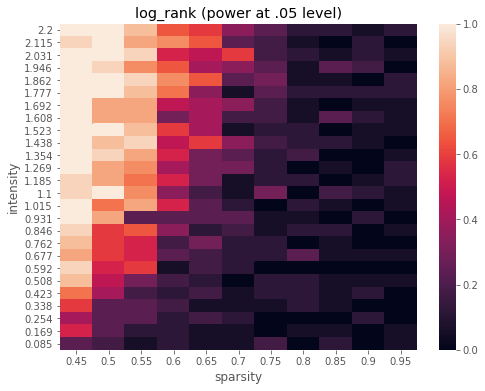

hc: both sides detected in 0.023035787741670095 of cases
(you should be worried if this number is significantly larger than 0.025)


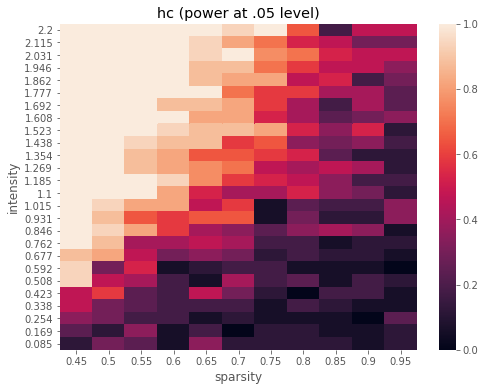

min_p: both sides detected in 0.02632661456190868 of cases
(you should be worried if this number is significantly larger than 0.025)


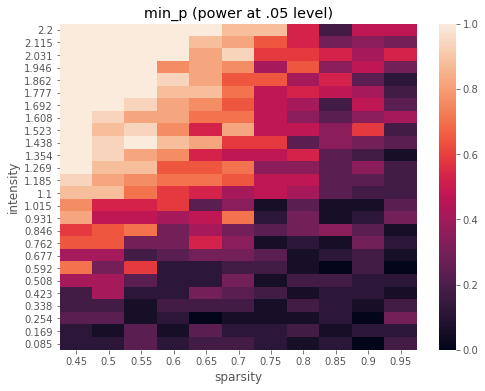

berk_jones: both sides detected in 0.014397367338543809 of cases
(you should be worried if this number is significantly larger than 0.025)


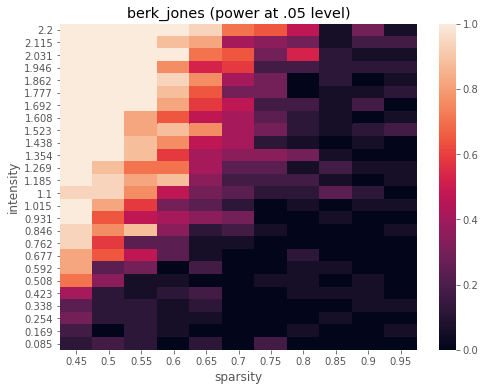

wilcoxon: both sides detected in 0.0 of cases
(you should be worried if this number is significantly larger than 0.025)


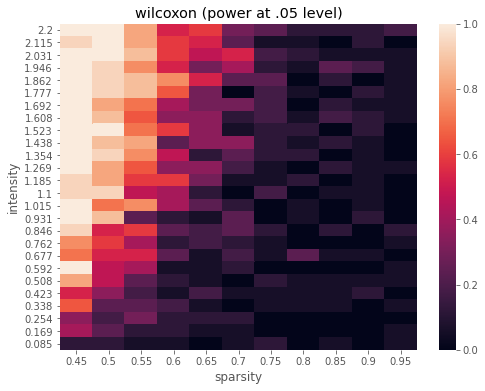

fisher: both sides detected in 0.0008227067050596463 of cases
(you should be worried if this number is significantly larger than 0.025)


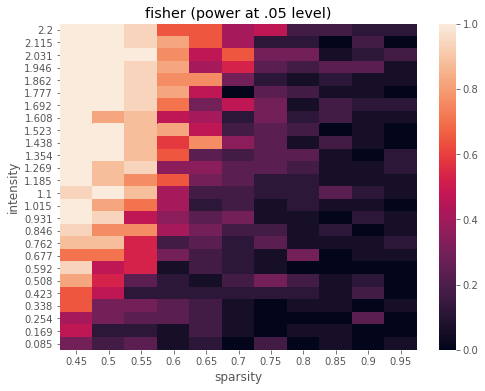

In [51]:
#def illustrate_phase_diagrams(df1, df0, out_filename='phase_diagram'):
"""

Args:
-----
:df1:   results from experiments under alternative 
:df0:   results from experiments under null
:out_filename:   file/path name to write to
"""


params = ['itr', 'T', 'N1', 'N2', 'r', 'beta']
tests = ['log_rank', 'hc', 'min_p', 'berk_jones', 'wilcoxon', 'fisher']
tests_vars = [c for c in df0.columns if c not in params and 'Unnamed' not in c]

global_params = ['T', 'N1', 'N2']
tcrit = df0.groupby(global_params).agg(q95)

good_side = 'greater'
bad_side = 'less'

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]

    for tsn in tests:
        name_good = tsn + '_' + good_side
        name_bad = tsn + '_' + bad_side

        # we check rate when both sides succedds. These are not good outcomes
        two_side_succ = ( dfc[name_good] > tcrit[name_good].values[0] ) & ( dfc[name_bad] > tcrit[name_bad].values[0] )
        print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
        print("(you should be worried if this number is significantly larger than 0.025)")

        bb = dfc['beta'].unique()
        rr = dfc['r'].unique()
        mat = np.zeros((len(bb), len(rr)))
        for i,beta in enumerate(bb):
            for j,r in enumerate(rr):
                dfs = dfc[(dfc['beta'] == beta) & (dfc['r'] == r) ]
                succ = dfs[name_good] > tcrit[name_good].values[0]
                mat[i,j] = np.mean(succ)

        plt.figure()
        g = seaborn.heatmap(mat[:,::-1].T)
        plt.title(f"{tsn} (power at .05 level)")
        g.set_xticklabels(bb)
        g.set_xlabel('sparsity')
        g.set_ylabel('intensity')
        #g.set_yticklabels(np.round(mm[::-1],3))
        g.set_yticklabels(np.round(rr[::-1],3))
        fn = out_filename + tsn + ".png"
        plt.savefig(fn)
        plt.show()

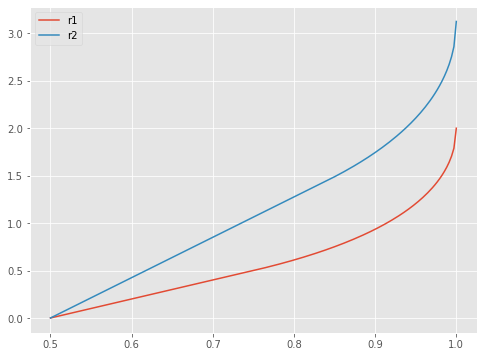

In [609]:
bb = np.linspace(0.5, 1, 171)

def rhos(be, sigma):
    if sigma**2 < 2:
        if be < 1 - sigma**2/4:
            return (2-sigma**2) * (be - 1/2)
        else:
            return (1-sigma*np.sqrt(1- be))**2
    else:
        if be < 1 - 1/sigma**2:
            return 0
        else:
            return (1-sigma*np.sqrt(1- be))**2

        
def plot_PT(r, sig):
    bb = np.linspace(0.5, 1, 171)
    rr = [rhos(b, sig) / r for b in bb]
    plt.plot(bb, rr)

            
kappa = 1/5

kappa_bar = 1 - kappa

r1 = 1 / 2
sig1 = 1

plot_PT(r1, sig1)

r2 = 2 * kappa * kappa_bar
sig2 = np.sqrt(4 * kappa * kappa_bar)

plot_PT(r2, sig2)

plt.legend(['r1', 'r2'])
plt.show()

In [347]:
from sample_poisson_data import *

<ipython-input-356-6c2616cdd073>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(xx, np.log(xx))
<ipython-input-356-6c2616cdd073>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xx, -1 / xx)


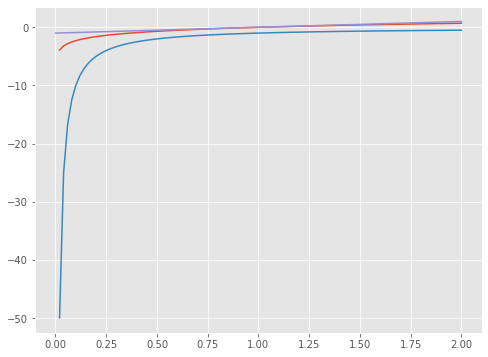

In [356]:
xx = np.linspace(0, 2, 101)

plt.plot(xx, np.log(xx))

0plt.plot(xx, -1 / xx)
plt.plot(xx, xx - 1)
